In [13]:
!pip install --upgrade wordcloud

In [16]:
# %% [1] IMPORT & SETUP
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from wordcloud import WordCloud
import joblib

APP_NAME = "Sapawarga"
APP_ID = "com.sapawarga.jds"
PLAYSTORE_URL = "https://play.google.com/store/apps/details?id=com.sapawarga.jds"

CLEAN_PATH = "sapawarga_reviews_clean.csv"
MODEL_PATH = "svm_sentiment_model_sapawarga.joblib"

print("OK: import selesai")
print("App:", APP_NAME, "|", APP_ID)


OK: import selesai
App: Sapawarga | com.sapawarga.jds


In [17]:
# %% [2] LOAD DATA CLEAN (UTAMA)
if not os.path.exists(CLEAN_PATH):
    raise FileNotFoundError(f"{CLEAN_PATH} tidak ditemukan. Taruh file di folder yang sama dengan notebook.")

df = pd.read_csv(CLEAN_PATH)
print("Shape:", df.shape)
print("Kolom:", df.columns.tolist())

if "text" not in df.columns or "label" not in df.columns:
    raise ValueError("CSV clean wajib punya kolom: text dan label")

df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

print("\nDistribusi label:")
print(df["label"].value_counts(dropna=False))
display(df.head())


Shape: (1084, 3)
Kolom: ['text', 'label', 'score']

Distribusi label:
label
0    592
1    492
Name: count, dtype: int64


,text,label,score
0,percuma fitur adu warga adu jelas tindaklanjutnya,0,1
1,bagus bantu,1,5
2,bayar online buat apa bos bos klw ujung panges...,0,1
3,gk daftar buat akun loding applikasi gk pakai ...,0,1
4,bagus cepat moga trus upgrade tegnologiny,1,5


In [18]:
# %% [3] TRAIN-TEST SPLIT
X = df["text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Distribusi train:", pd.Series(y_train).value_counts().to_dict())
print("Distribusi test :", pd.Series(y_test).value_counts().to_dict())


Train: (867,) Test: (217,)
Distribusi train: {0: 473, 1: 394}
Distribusi test : {0: 119, 1: 98}


In [19]:
# %% [4] HELPER PLOT CONFUSION MATRIX (matplotlib saja)
def plot_confusion(cm, title):
    labels = ["Negatif (0)", "Positif (1)"]
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha="right")
    plt.yticks(ticks, labels)

    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

Accuracy (Linear): 0.8294930875576036

Classification Report (Linear):
              precision    recall  f1-score   support

           0     0.8060    0.9076    0.8538       119
           1     0.8675    0.7347    0.7956        98

    accuracy                         0.8295       217
   macro avg     0.8367    0.8211    0.8247       217
weighted avg     0.8337    0.8295    0.8275       217

Confusion Matrix (Linear):
 [[108  11]
 [ 26  72]]


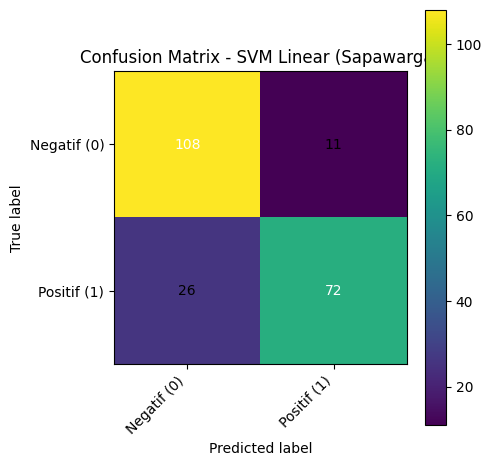

In [20]:
# %% [5] MODEL 1: SVM LINEAR
svm_linear = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel="linear")
)

svm_linear.fit(X_train, y_train)
pred_linear = svm_linear.predict(X_test)

acc_linear = accuracy_score(y_test, pred_linear)
cm_linear = confusion_matrix(y_test, pred_linear, labels=[0, 1])

print("Accuracy (Linear):", acc_linear)
print("\nClassification Report (Linear):")
print(classification_report(y_test, pred_linear, digits=4))
print("Confusion Matrix (Linear):\n", cm_linear)
plot_confusion(cm_linear, f"Confusion Matrix - SVM Linear ({APP_NAME})")


Accuracy (RBF): 0.847926267281106

Classification Report (RBF):
              precision    recall  f1-score   support

           0     0.8028    0.9580    0.8736       119
           1     0.9333    0.7143    0.8092        98

    accuracy                         0.8479       217
   macro avg     0.8681    0.8361    0.8414       217
weighted avg     0.8618    0.8479    0.8445       217

Confusion Matrix (RBF):
 [[114   5]
 [ 28  70]]


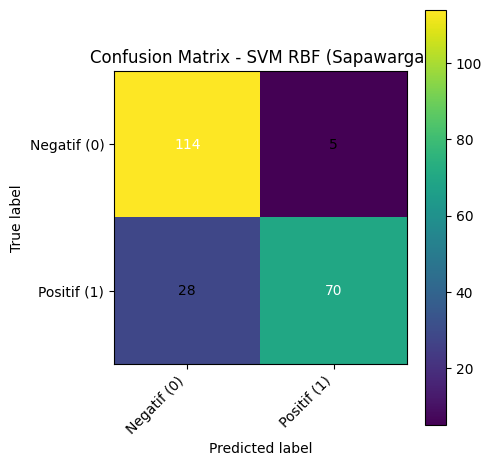

In [21]:
# %% [6] MODEL 2: SVM RBF
svm_rbf = make_pipeline(
    TfidfVectorizer(),
    SVC(kernel="rbf")
)

svm_rbf.fit(X_train, y_train)
pred_rbf = svm_rbf.predict(X_test)

acc_rbf = accuracy_score(y_test, pred_rbf)
cm_rbf = confusion_matrix(y_test, pred_rbf, labels=[0, 1])

print("Accuracy (RBF):", acc_rbf)
print("\nClassification Report (RBF):")
print(classification_report(y_test, pred_rbf, digits=4))
print("Confusion Matrix (RBF):\n", cm_rbf)
plot_confusion(cm_rbf, f"Confusion Matrix - SVM RBF ({APP_NAME})")


In [22]:
# %% [7] ANALISIS ERROR (contoh salah prediksi)
def show_misclassified(X_test, y_true, y_pred, n=10):
    idx = np.where(y_true.values != y_pred)[0]
    print("Jumlah salah prediksi:", len(idx))
    for k, i in enumerate(idx[:n], 1):
        print("-" * 70)
        print(f"{k}. TRUE={y_true.values[i]} | PRED={y_pred[i]}")
        print(X_test.values[i])

print("=== Misclassified (Linear) ===")
show_misclassified(X_test, y_test, pred_linear, n=10)

print("\n=== Misclassified (RBF) ===")
show_misclassified(X_test, y_test, pred_rbf, n=10)


=== Misclassified (Linear) ===
Jumlah salah prediksi: 37
----------------------------------------------------------------------
1. TRUE=1 | PRED=0
eror loding mulu
----------------------------------------------------------------------
2. TRUE=0 | PRED=1
mengapdate versi baru susah
----------------------------------------------------------------------
3. TRUE=1 | PRED=0
blokir kendara blm
----------------------------------------------------------------------
4. TRUE=1 | PRED=0
fitur lepas milik kendara
----------------------------------------------------------------------
5. TRUE=1 | PRED=0
segera baik bayar pajak motor mind
----------------------------------------------------------------------
6. TRUE=1 | PRED=0
lmot kurang satset bnyak gagal server trus
----------------------------------------------------------------------
7. TRUE=1 | PRED=0
fitur samsat yg kata bpk gubernur nabung buat pkb
----------------------------------------------------------------------
8. TRUE=0 | PRED=1
mah s

TypeError: asarray() got an unexpected keyword argument 'copy'

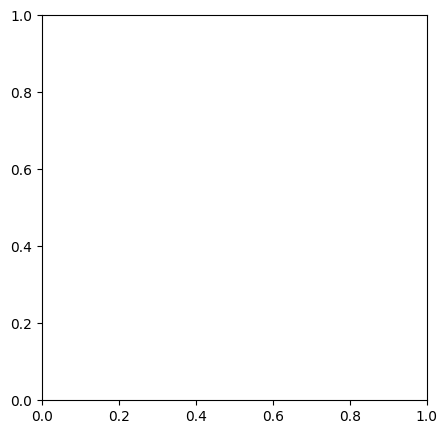

In [ ]:
# %% [8] WORDCLOUD (wajib 2: positif & negatif)
pos_text = " ".join(df.loc[df["label"] == 1, "text"].astype(str).tolist())
neg_text = " ".join(df.loc[df["label"] == 0, "text"].astype(str).tolist())

def show_wordcloud(text, title):
    wc = WordCloud(width=1000, height=500, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    # Fix: Konversi ke numpy array dengan cara yang kompatibel
    # Menggunakan to_image() dan konversi ke array untuk menghindari error numpy
    import numpy as np
    img = wc.to_image()
    img_array = np.array(img)
    plt.imshow(img_array, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

show_wordcloud(pos_text, f"WordCloud - Positif ({APP_NAME})")
show_wordcloud(neg_text, f"WordCloud - Negatif ({APP_NAME})")


In [9]:
# %% [9] TUNING SEDERHANA (C / GAMMA)
pipe_linear = make_pipeline(TfidfVectorizer(), SVC(kernel="linear"))
grid_linear = {"svc__C": [0.1, 1, 3, 10]}

gs_linear = GridSearchCV(pipe_linear, grid_linear, cv=5, n_jobs=-1)
gs_linear.fit(X_train, y_train)
best_linear = gs_linear.best_estimator_
pred_best_linear = best_linear.predict(X_test)
acc_best_linear = accuracy_score(y_test, pred_best_linear)

print("Best Linear Params:", gs_linear.best_params_)
print("Accuracy Best Linear:", acc_best_linear)

pipe_rbf = make_pipeline(TfidfVectorizer(), SVC(kernel="rbf"))
grid_rbf = {"svc__C": [0.3, 1, 3, 10], "svc__gamma": ["scale", 0.1, 0.01]}

gs_rbf = GridSearchCV(pipe_rbf, grid_rbf, cv=5, n_jobs=-1)
gs_rbf.fit(X_train, y_train)
best_rbf = gs_rbf.best_estimator_
pred_best_rbf = best_rbf.predict(X_test)
acc_best_rbf = accuracy_score(y_test, pred_best_rbf)

print("Best RBF Params:", gs_rbf.best_params_)
print("Accuracy Best RBF:", acc_best_rbf)


Best Linear Params: {'svc__C': 1}
Accuracy Best Linear: 0.8294930875576036
Best RBF Params: {'svc__C': 3, 'svc__gamma': 0.1}
Accuracy Best RBF: 0.8525345622119815


In [10]:
# %% [10] SIMPAN MODEL TERBAIK UNTUK STREAMLIT
candidates = [
    ("svm_linear", svm_linear, acc_linear),
    ("svm_rbf", svm_rbf, acc_rbf),
    ("best_linear", best_linear, acc_best_linear),
    ("best_rbf", best_rbf, acc_best_rbf),
]
candidates = sorted(candidates, key=lambda x: x[2], reverse=True)

best_name, best_model, best_acc = candidates[0]
print("Model terbaik:", best_name, "| Acc:", best_acc)

joblib.dump(best_model, MODEL_PATH)
print("Model tersimpan:", MODEL_PATH)

sample_texts = [
    "aplikasi sangat membantu dan mudah digunakan",
    "sering error dan susah dipakai mengecewakan"
]
print("Prediksi contoh:", best_model.predict(sample_texts))

Model terbaik: best_rbf | Acc: 0.8525345622119815
Model tersimpan: svm_sentiment_model_sapawarga.joblib
Prediksi contoh: [1 0]
